In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import jax
import jax.numpy as jnp
from jax import random

from jax import config
config.update("jax_enable_x64", False)

import numpy as np

import numpyro
numpyro.set_host_device_count(4)
numpyro.set_platform('cpu')
from numpyro.infer import MCMC, NUTS

import model

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
nuts_kernel = NUTS(model.model)

In [4]:
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1000, num_chains=4)

prng_key = random.PRNGKey(13)

In [129]:
times = jnp.linspace(0, 10, 200)

## signal
A, B = 1, -1
omega, gamma = 7, 1

h_mu = jnp.exp(-gamma*times) * (A * jnp.cos(omega*times) + B * jnp.sin(omega*times))

## noise
T = 2
x = 0.9
h_cov = model.cov_func(times, x, T, omega, gamma)

data_err = jnp.ones(times.shape)

In [130]:
y = random.multivariate_normal(key=prng_key, mean=h_mu, cov=h_cov, method='svd')

<Axes: ylabel='Count'>

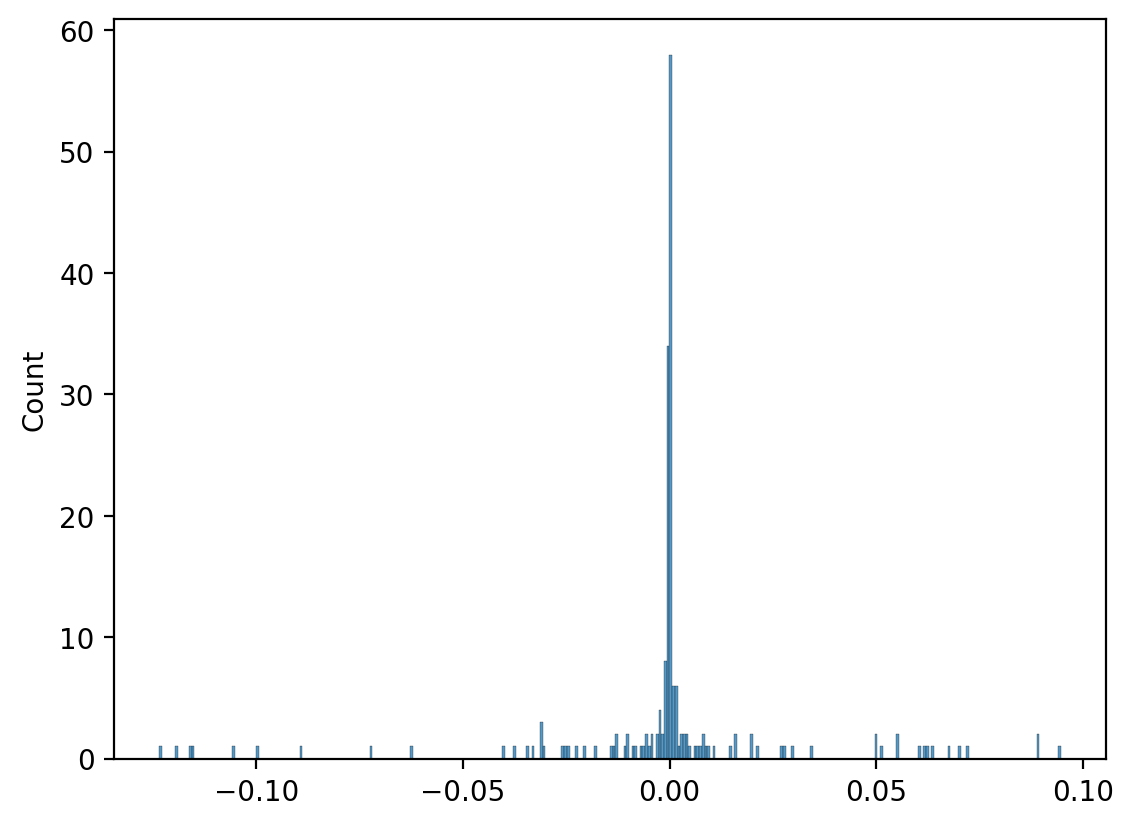

In [131]:
sns.histplot(random.multivariate_normal(key=prng_key, mean=jnp.zeros(times.shape), cov=h_cov, method='svd'))

In [132]:
w = random.multivariate_normal(key=prng_key, mean=jnp.zeros(times.shape), cov=jnp.diag(data_err**2))
w.shape

(200,)

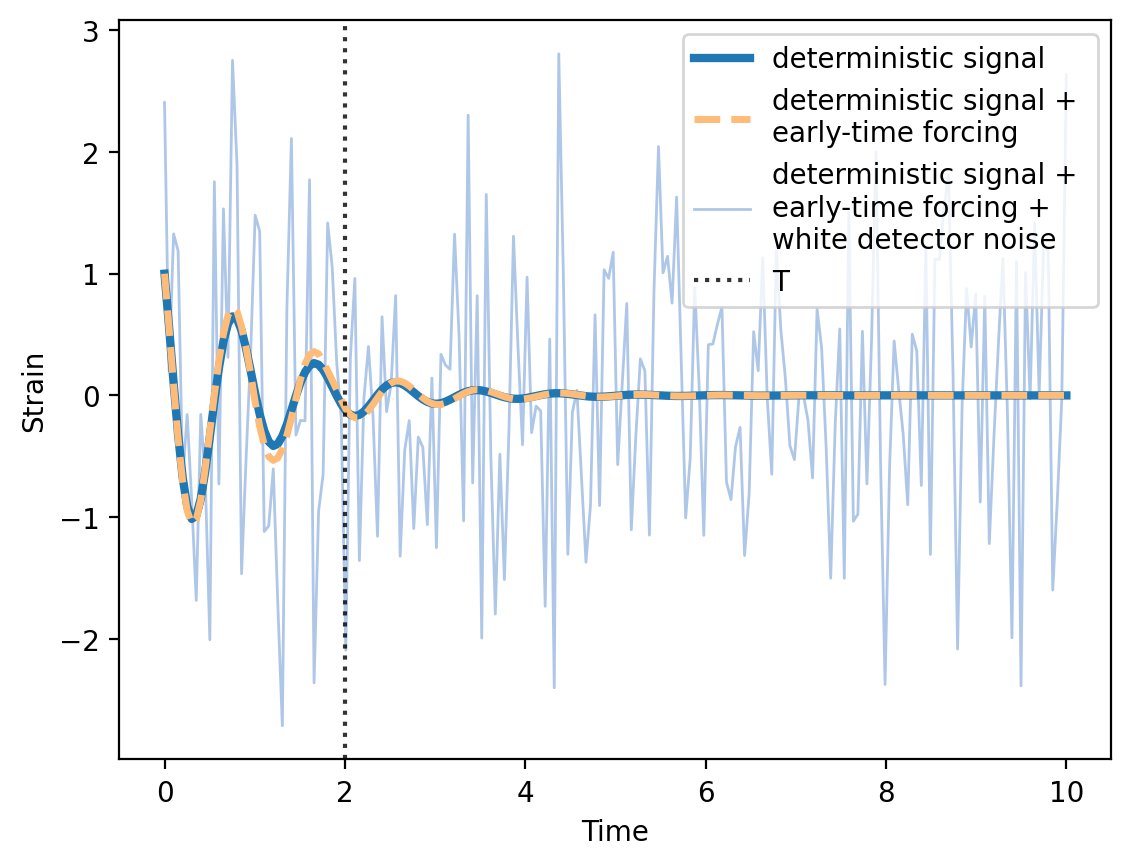

In [133]:
plt.plot(times, h_mu, lw=3, color=sns.color_palette('tab20')[0], label='deterministic signal')
plt.plot(times, y, ls='--', lw=2.5, color=sns.color_palette('tab20')[3], label='deterministic signal + \nearly-time forcing')
plt.plot(times, y+w, lw=1, color=sns.color_palette('tab20')[1], label='deterministic signal +\nearly-time forcing +\nwhite detector noise', zorder=-1)

plt.xlabel('Time')
plt.ylabel('Strain')

plt.axvline(T, ls=':', c='k', alpha=0.8, label='T')

plt.legend()

In [134]:
mcmc.run(prng_key, times, y, data_err, omega_bounds=[0, 10], gamma_bounds=[0, 10], T_bounds=[1e-3, 10])

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [135]:
import arviz as az

idata = az.from_numpyro(mcmc)

array([[<Axes: title={'center': 'A'}>, <Axes: title={'center': 'A'}>],
       [<Axes: title={'center': 'B'}>, <Axes: title={'center': 'B'}>],
       [<Axes: title={'center': 'T'}>, <Axes: title={'center': 'T'}>],
       [<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: title={'center': 'omega'}>,
        <Axes: title={'center': 'omega'}>],
       [<Axes: title={'center': 'x'}>, <Axes: title={'center': 'x'}>]],
      dtype=object)

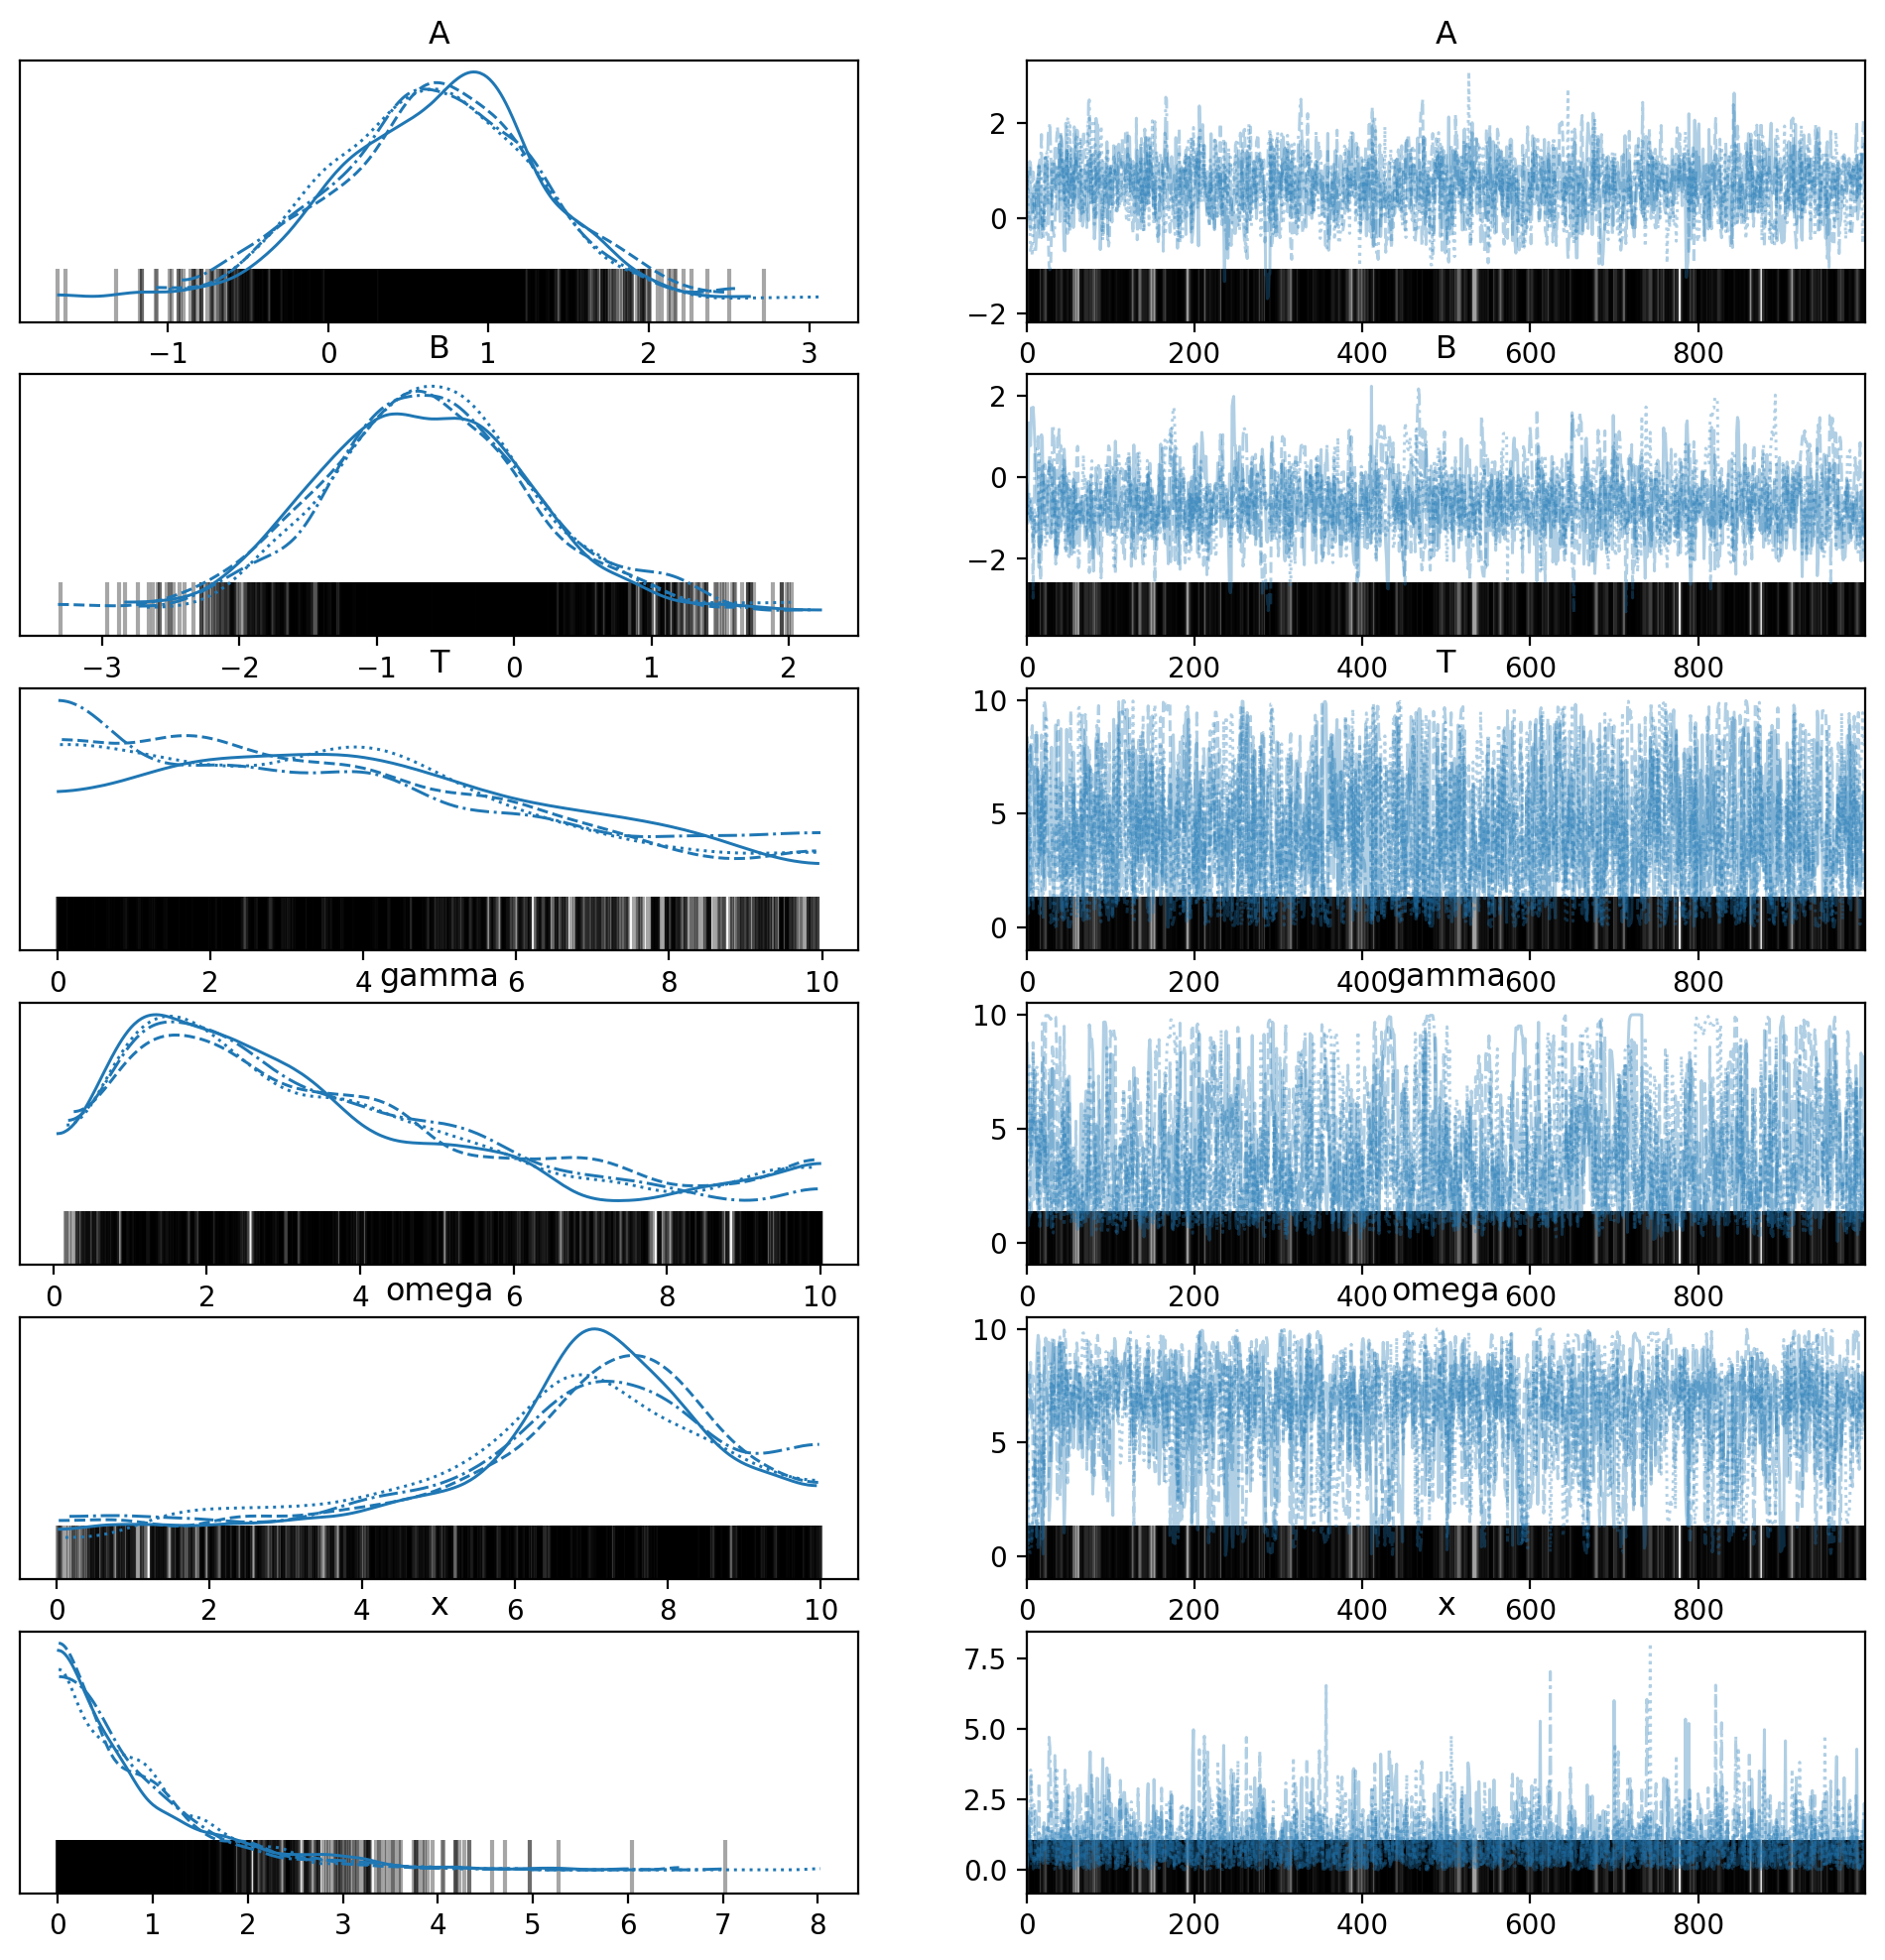

In [136]:
az.plot_trace(idata)

array([[<Axes: ylabel='A'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='B'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='x'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='T'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='omega'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: xlabel='A', ylabel='gamma'>, <Axes: xlabel='B'>,
        <Axes: xlabel='x'>, <Axes: xlabel='T'>, <Axes: xlabel='omega'>,
        <Axes: xlabel='gamma'>]], dtype=object)

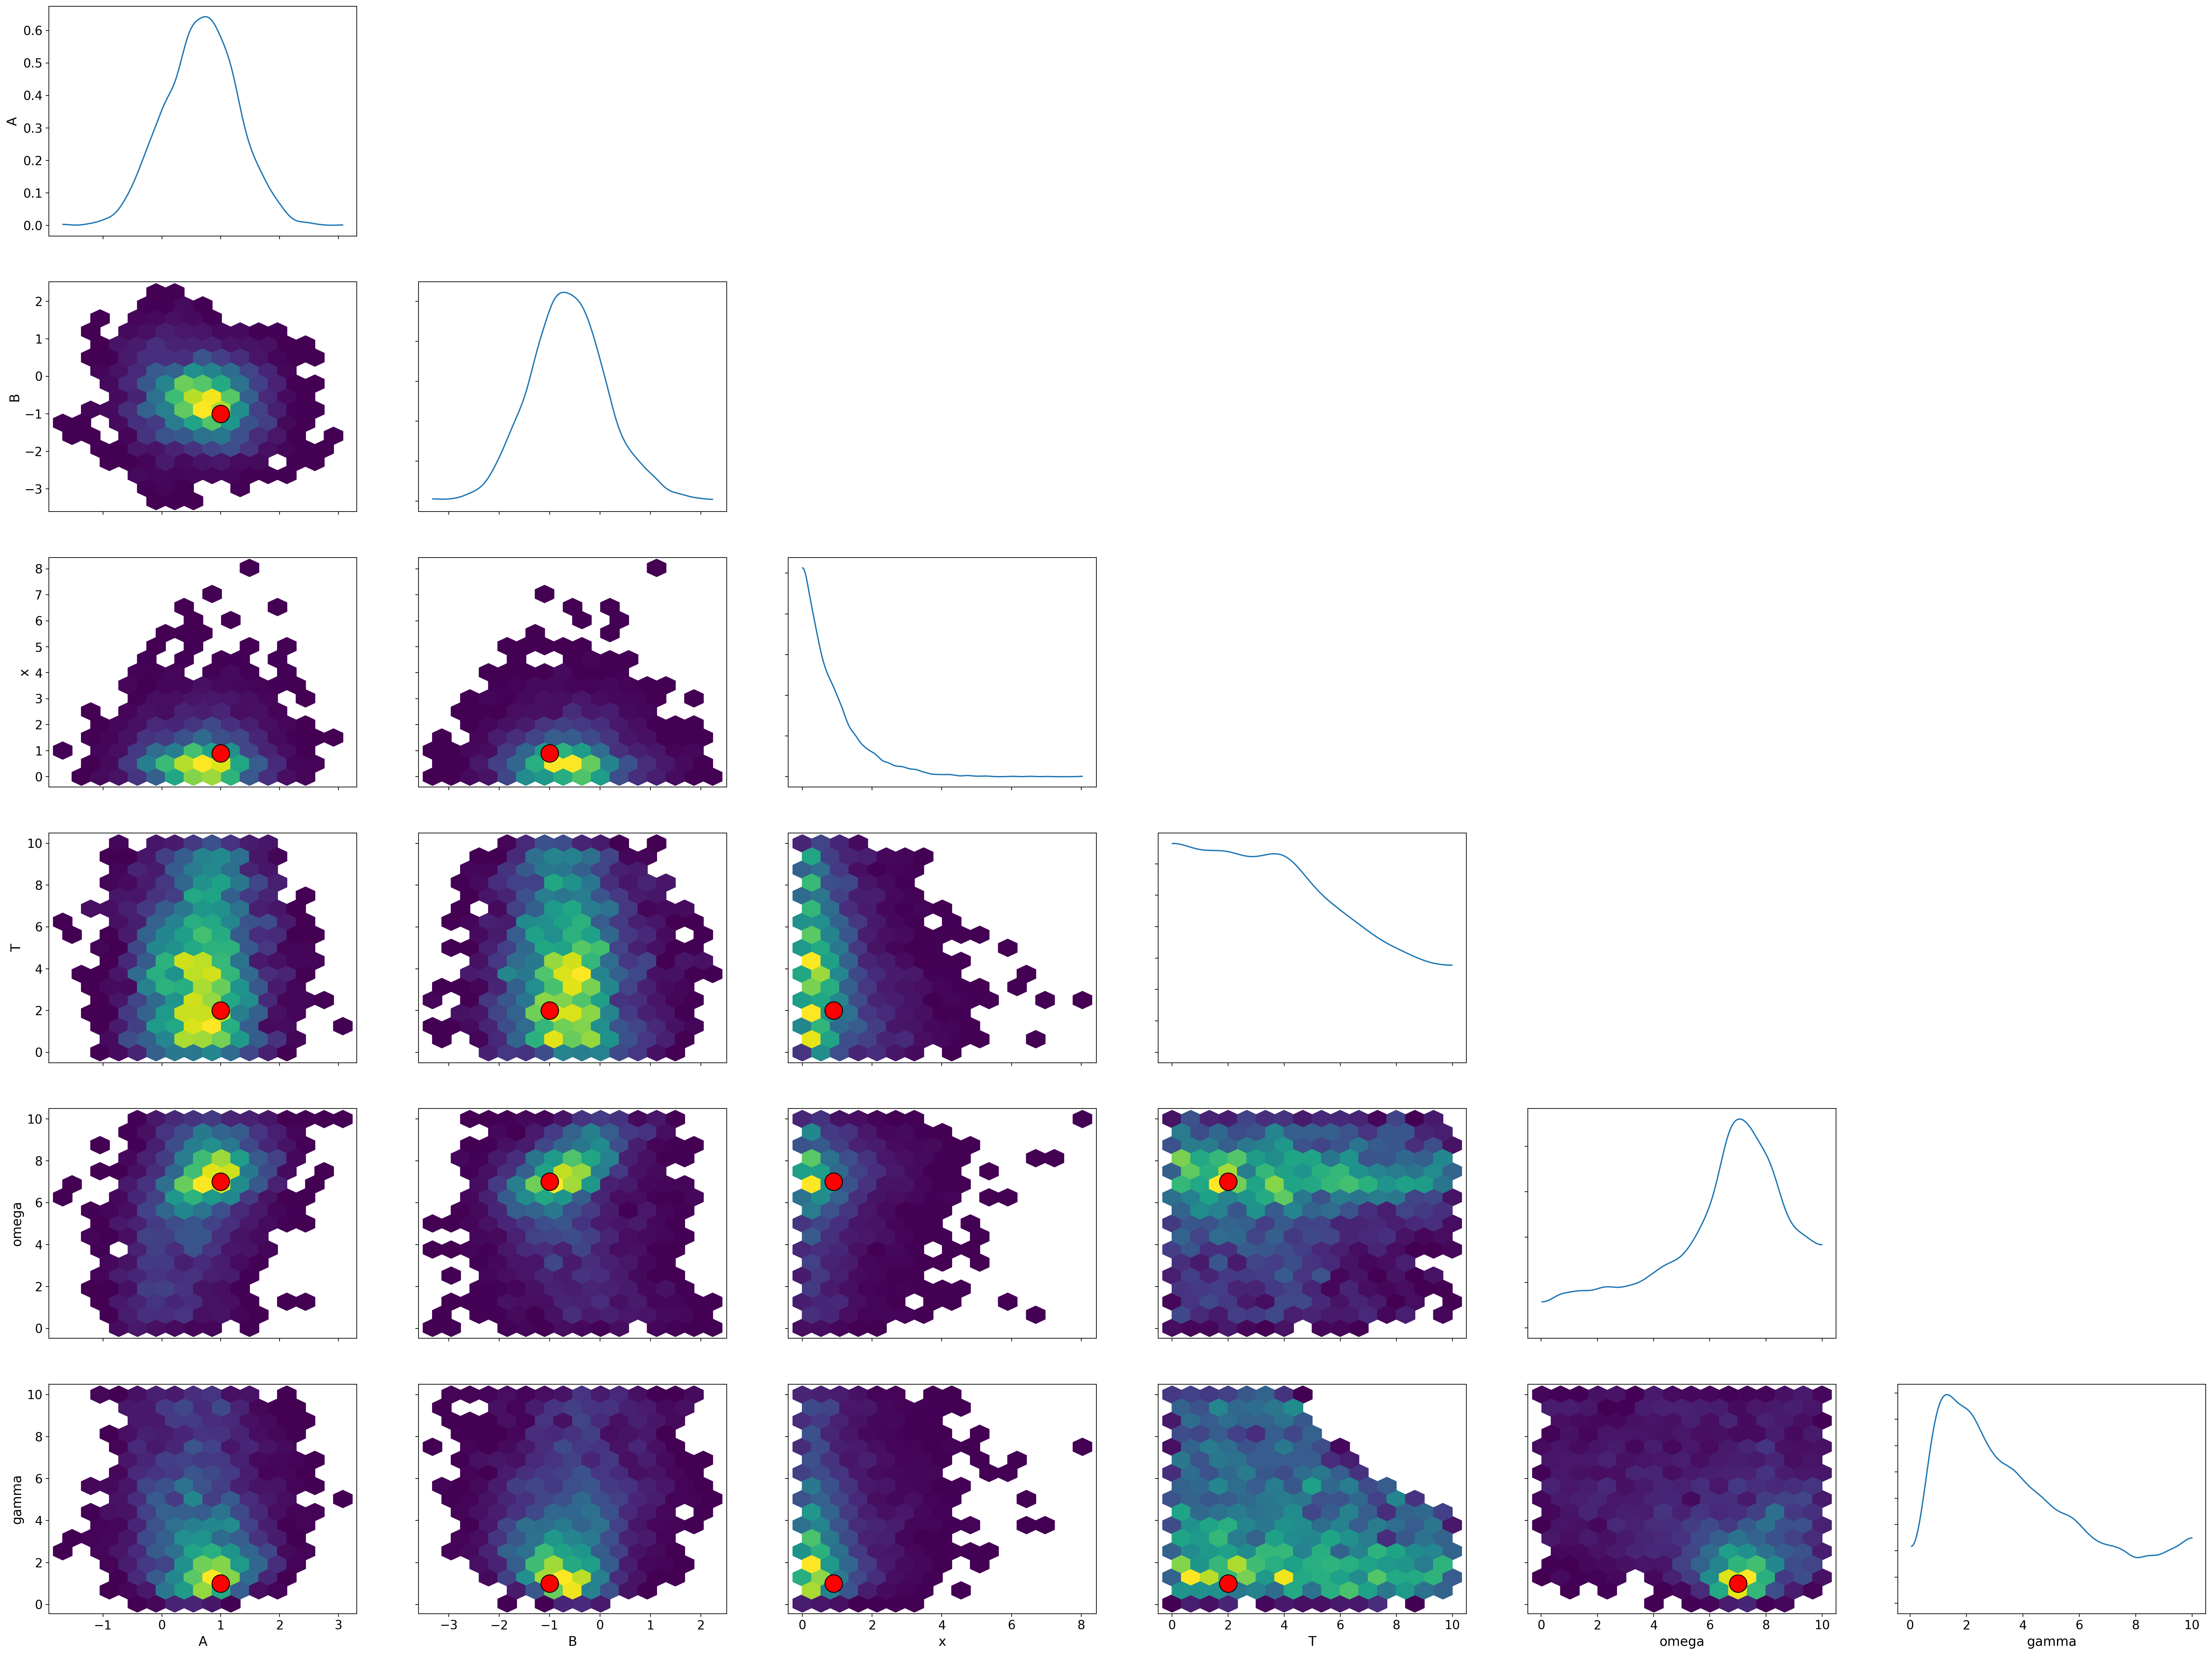

In [137]:
az.plot_pair(idata, var_names=['A', 'B', 'x', 'T', 'omega', 'gamma'], marginals=True,
             reference_values={'A': A, 'B':B, 'x': x, 'T': T, 'omega':omega, 'gamma':gamma},
             reference_values_kwargs={'color':'red', 'lw':3, 'markersize':20}, kind='hexbin', gridsize=15)